In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
clear = lambda: os.system('clear')


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/models/model_vannila.pt
/kaggle/input/models/model_attention.pt
/kaggle/input/anjali/AnjaliOldLipi-Regular.woff
/kaggle/input/anjali/AnjaliOldLipi-Regular.woff2
/kaggle/input/anjali/AnjaliOldLipi-Regular.ttf
/kaggle/input/aksharantar/aksharantar_sampled/brx/brx_test.csv
/kaggle/input/aksharantar/aksharantar_sampled/brx/brx_valid.csv
/kaggle/input/aksharantar/aksharantar_sampled/brx/brx_train.csv
/kaggle/input/aksharantar/aksharantar_sampled/tam/tam_valid.csv
/kaggle/input/aksharantar/aksharantar_sampled/tam/tam_train.csv
/kaggle/input/aksharantar/aksharantar_sampled/tam/tam_test.csv
/kaggle/input/aksharantar/aksharantar_sampled/mni/mni_valid.csv
/kaggle/input/aksharantar/aksharantar_sampled/mni/mni_test.csv
/kaggle/input/aksharantar/aksharantar_sampled/mni/mni_train.csv
/kaggle/input/aksharantar/aksharantar_sampled/urd/urd_train.csv
/kaggle/input/aksharantar/aksharantar_sampled/urd/urd_valid.csv
/kaggle/input/aksharantar/aksharantar_sampled/urd/urd_test.csv
/kaggle/input/

### ALL NECESSARY IMPORTS

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 

from tqdm import tqdm
import heapq
import csv

import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import wandb
# Instantiates the device to be used as GPU/CPU based on availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:
# Wandb key
KEY = 'c425b887e2c725018a7f3a772582610fa54ef52c'

In [3]:
#specify max length of sequence
mal_embedd_size = 29
eng_embedd_size = 32
device.type

'cuda'

### PREPROCESSING STEP

In [4]:
# Load Data to capture all characters
arr = np.loadtxt("/kaggle/input/aksharantar/aksharantar_sampled/mal/mal_train.csv",
                 delimiter=",", dtype=str)
num_sample = arr.shape[0]
x_train,y_train = arr[:,0],arr[:,1]
english_index = 3
mal_index = 3
english_dict = {}
malayalam_dict = {}
english_index_dict = {}
malayalam_index_dict = {}

# Create dictionary for malayalam and english

for i in range(num_sample):
    for j in range(len(x_train[i])):
        
        if(english_dict.get(x_train[i][j]) == None):
            english_dict[x_train[i][j]]=english_index
            english_index_dict[english_index] = x_train[i][j]
            english_index+=1
        
    for j in range(len(y_train[i])):
            
        if(malayalam_dict.get(y_train[i][j]) == None):
            malayalam_dict[y_train[i][j]]=mal_index
            malayalam_index_dict[mal_index] = y_train[i][j]
            mal_index+=1

In [5]:
# Adding start, stop and padding symbols
malayalam_index_dict[1] = '<S>'
english_index_dict[1] = '<S>'

malayalam_index_dict[2] = '<E>'
english_index_dict[2] = '<E>'

malayalam_index_dict[0] = '<P>'
english_index_dict[0] = '<P>'

In [6]:
# Function to load data from the data set and create and array corresponding to it

def loadData(PATH = "/kaggle/input/aksharantar/aksharantar_sampled/mal/mal_test.csv"):  
    
    arr = np.loadtxt(PATH,
                 delimiter=",", dtype=str)
    num_sample = arr.shape[0]
    x,y = arr[:,0],arr[:,1]
    X = np.zeros((num_sample,eng_embedd_size)) # input
    Y = np.zeros((num_sample,mal_embedd_size)) # target

    for i in range(num_sample):

        X[i][0] = 1
        Y[i][0] = 1
        for j in range(len(x[i])):
            if(english_dict.get(x[i][j]) != None):
                X[i][j+1] = english_dict[x[i][j]]
            else:
                X[i][j+1] = 0

        X[i][len(x[i])+1]=2

        for j in range(len(y[i])):
            if(malayalam_dict.get(y[i][j]) != None):
                Y[i][j+1] = malayalam_dict[y[i][j]]
            else:
                Y[i][j+1] = 0

        Y[i][len(y[i])+1] = 2
        
    return X, Y

In [7]:
# Load all data with specified path
X_train,y_train = loadData(PATH = "/kaggle/input/aksharantar/aksharantar_sampled/mal/mal_train.csv")
X_val,y_val = loadData(PATH = "/kaggle/input/aksharantar/aksharantar_sampled/mal/mal_valid.csv")
X_test,y_test = loadData(PATH = "/kaggle/input/aksharantar/aksharantar_sampled/mal/mal_test.csv")

In [8]:
# Class to create dataset, so can be passed to pytorch dataloader
class MakeDataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.int64)
        self.y = torch.tensor(y,dtype=torch.int64)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

  
    def __len__(self):
        return self.len

In [9]:
# Create dataset to pass to dataloader

train_dataset = MakeDataset(X_train,y_train)
val_dataset = MakeDataset(X_val, y_val)
test_dataset = MakeDataset(X_test, y_test)

In [10]:
# Create dataloader so getting data in epochs is easy
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=256)
val_loader = DataLoader(val_dataset,shuffle=True,batch_size=256)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=256)

## ENCODER MODULE

In [11]:
class Encoder(nn.Module):
    '''
     Encoder network in which hidden size, input dimension, embedding dimension, etc 
     can be specified for training.
    '''
    def __init__(self,
                    input_dimension = 72,
                    embed_dimension = 64,
                    hidden_dimension = 256,
                    cell_type = 'gru',
                    layers = 2,
                    bidirectional = True,
                    dropout = 0,
                    device = device
                ):
        
        super(Encoder, self).__init__()

        self.detail_parameters = {
            'input_dimension' : input_dimension,
            'embed_dimension' : embed_dimension,
            'hidden_dimension' : hidden_dimension,
            'cell_type' : cell_type,
            'dropout' : dropout,
            'layers' : layers,
            'direction_value' : 2 if bidirectional else 1,
            'device' : device.type,
        }
        
        # total number of english characters
        self.input_dimension = input_dimension
        
        # Dimension to which we need to embed our source
        self.embed_dimension = embed_dimension
        
        # Embedding the input
        self.embedding = nn.Embedding(self.input_dimension, self.embed_dimension)
        
        
        
        # Number of neurons in hidden layers
        self.hidden_dimension = hidden_dimension
        
        # Which type to use - RNN, GRU, LSTM
        self.cell_type = cell_type
        
        # Number of layers for hidden 
        self.layers = layers
        
        
        # Dropout to add onto embedded input
        self.dropout = nn.Dropout(dropout)
        
        # If bidirection then hidden size must be doubled.
        if bidirectional :
            self.direction_value = 2 
        else :
            self.direction_value = 1
        
        #device to use gpu or cpu
        self.device = device

        

        if self.cell_type == 'rnn':
            # type of cell to use is rnn
            self.encoder_type = nn.RNN(
                          input_size= self.embed_dimension,
                          num_layers= self.layers,
                          hidden_size= self.hidden_dimension,
                          dropout = dropout,
                          bidirectional= bidirectional)
            
        elif self.cell_type == "gru":
            # type of cell to use is gru
            self.encoder_type = nn.GRU(
                          input_size= self.embed_dimension,
                          num_layers= self.layers,
                          hidden_size= self.hidden_dimension,
                          dropout = dropout,
                          bidirectional= bidirectional)
        elif self.cell_type == "lstm":
            # type of cell to use is lstm
            self.encoder_type = nn.LSTM(
                          input_size= self.embed_dimension,
                          num_layers= self.layers,
                          hidden_size= self.hidden_dimension,
                          dropout = dropout,
                          bidirectional= bidirectional)
            
            
    def forward(self, input, hidden, cell=None):
        
        # First convert sequence to embedding
        embedded = self.embedding(input)
        
        # Apply dropout also
        embedded = self.dropout(embedded)
        
        #Then choose type of rnn to run using pytorch 
        if self.cell_type == 'lstm':
            output,(hidden,cell) = self.encoder_type(embedded, (hidden,cell))
        else:
            output, hidden = self.encoder_type(embedded, hidden)

        return output, hidden, cell

    def getParams(self):
        return self.detail_parameters
    
    def init_hidden(self, batch):
        # Initialize the hidden state to zeros
        return torch.zeros(self.direction_value*self.layers,batch,self.hidden_dimension,device=device)
        
    

## DECODER MODULE

In [26]:
class Decoder(nn.Module):
    '''
    Decoder to decode to malayalam word. It also contain different parameters
    which is specified in the contructor. 
    '''
    def __init__(self,
                input_dimension = 26,
                embed_dimension = 64,
                hidden_dimension = 256,
                cell_type = 'lstm',
                layers = 2,
                use_attention = False,
                attention_dimension = None,
                dropout = 0,
                bidirectional = True,
                device = device
                 ):
        
        super(Decoder, self).__init__()
        
        self.detail_parameters = {
            'input_dimension' : input_dimension,
            'embed_dimension' : embed_dimension,
            'hidden_dimension' : hidden_dimension,
            'attention_dimension':attention_dimension,
            'cell_type' : cell_type,
            'layers' : layers,
            'device' : device.type,
            'dropout' : dropout,
            'use_attention' : use_attention,
            'attention_dimension' : attention_dimension,
        }

        # total number of malayalam characters
        self.input_dimension = input_dimension
        
        # Dimension to which we need to embed our input
        self.embed_dimension = embed_dimension  
        
        # Embedding the input
        self.embedding = nn.Embedding(self.input_dimension, self.embed_dimension)
        
        # Real input size given to nn.Decoder including attention dimension
        self.input_size = embed_dimension
        
        # Attention dimension
        self.attention_dimension = 0
        
        # Number of neurons in hidden layers
        self.hidden_dimension = hidden_dimension
        
        # If attention is being used then set this variable
        self.use_attention = use_attention
        
        # After applying weight, what should be the dimension should be
        self.attention_out_dimension = 1
        
        # Which type to use - RNN, GRU, LSTM
        self.cell_type = cell_type
        
        # Number of layers for hidden
        self.layers = layers
        
        # device to use gpu or cpu
        self.device = device
        
        # Dropout to add onto embedded input
        self.dropout = nn.Dropout(dropout)
        
        
        
        if bidirectional :
            self.direction_value = 2 
        else :
            self.direction_value = 1
            
        # Weights to multiply output we get from decoder
        self.W1 = nn.Linear(self.hidden_dimension*self.direction_value, self.input_dimension)
#         self.R = nn.LeakyReLU()
        self.W2 = nn.Linear(self.embed_dimension, self.input_dimension)
        
        self.softmax = F.softmax

        if self.use_attention:
            self.attention_dimension = attention_dimension
            self.input_size += self.attention_dimension
            
            # Initialize 3 weight matrices, so we can muliply for attention
            self.U = nn.Sequential(nn.Linear( self.hidden_dimension, self.hidden_dimension), nn.LeakyReLU())
            self.W = nn.Sequential(nn.Linear( self.hidden_dimension, self.hidden_dimension), nn.LeakyReLU())
            self.V = nn.Sequential(nn.Linear( self.hidden_dimension, self.attention_out_dimension), nn.LeakyReLU())
        
        

        if self.cell_type == 'rnn':
            # type of cell to use is rnn
            self.decoder_type = nn.RNN(input_size= self.input_size,
                            dropout = dropout,     
                            num_layers= self.layers,
                            hidden_size= self.hidden_dimension,
                            bidirectional= bidirectional
                                 )
        elif self.cell_type == 'gru':
            # type of cell to use is gru
            self.decoder_type = nn.GRU(input_size= self.input_size, # to concat attention_output
                            num_layers= self.layers,
                            hidden_size= self.hidden_dimension,
                            dropout = dropout,
                            bidirectional= bidirectional
                                 )
        elif self.cell_type == "lstm":
            # type of cell to use is lstm
            self.decoder_type = nn.LSTM(input_size= self.input_size,
                            num_layers= self.layers,
                            hidden_size= self.hidden_dimension,
                            dropout = dropout,
                            bidirectional= bidirectional
                                  )


    def getParams(self):
        return self.detail_parameters
    
    def applyAttention(self, hidden, enc_output):
        
        '''
        It uses attention mechanism to include encoders weights to decoder.
        '''
        encoder_transform  = self.W(enc_output)
        hidden_transform =  self.U(hidden)

        concat_transform = encoder_transform + hidden_transform
        score = torch.tanh(concat_transform)
        
        score = self.V(score)

        # This will be our probability distribution for the attention weights (alpha)
        attention_weights = torch.softmax(score, dim=0)
        
        # conext vector to be concatenated to input
        context_vector = attention_weights * enc_output
        
        # To make dimension correct after attention
        normalized_context_vector = torch.sum(context_vector,dim=0)
        normalized_context_vector = torch.sum(normalized_context_vector,dim=0).unsqueeze(0)
        
        return normalized_context_vector,attention_weights
    
    def forward(self, input, hidden, cell=None,encoder_outputs=None):
#         Incorporate dropout in embedding.
        output = self.dropout(self.embedding(input))
    
        attention_weights = None
#         If we are using attention, then we need to concatenate the context vector, which we obtain from attention
        
        if self.use_attention:
            context,attention_weights = self.applyAttention(hidden, encoder_outputs)
            output = torch.cat((output,context),2)
        
        if self.cell_type == 'lstm':
            output,(hidden,cell) = self.decoder_type(output,(hidden,cell))
        else:
            output, hidden = self.decoder_type(output, hidden)
            
        
        output = self.W1(output)
#         output = self.R(output)
#         output = self.W2(output)
        
        return output, hidden, cell, attention_weights

    

In [27]:
class BeamNode(object):
    '''
    Beam search uses this class's object as nodes to store all relevent information
    '''
    def __init__(self, probability = 1, path_probability = 0, index = 1, hidden = None, cell = None, parent = None):
        # Probability of this character for predicted
        self.probability = probability
        # Total probability of the path
        self.path_probability = path_probability
        # index to store, so can be passed as input
        self.index = index
        # store the next element
        self.parent = parent
        # To store the prev hidden
        self.hidden = hidden
        # To store previous cell in case of lstm
        self.cell = cell
        # To store path length
        self.length = 0
    
    def __lt__(self, other):
        # As heapq works on min heap, override less than in a way such that highest pah prob will be taken
        return self.path_probability > other.path_probability

In [28]:
class BeamSearch():
    '''
    Use beam search heuristics to decode. Here it is similar to bfs, but we only choose top k nodes to proceed
    where k is the beam width.
    '''
    def __init__(self, beam_width = 3):
        
        # Beam width
        self.beam_width = beam_width 
        
        # To store the nodes to be explored
        self.open_list = []
        
        # make it into heap
        heapq.heapify(self.open_list)
        
        # To store all (based on beam width) probable paths
        self.paths = []
        
        
    def beamSearch(self, model, outputs,dec_hiddens,cells, predicted):
        batch_size = outputs.shape[1]
        
        for i in range(batch_size):
            with torch.no_grad():
                model.eval()
                output = outputs[:,i:i+1].contiguous()
                index = output.contiguous()
                dec_hidden = dec_hiddens[:,i:i+1,:].contiguous()
                cell = cells[:,i:i+1,:].contiguous() if cells is not None else None
                
                # create root node => which has 1 (start index) as the element
                node = BeamNode(1,1,index,dec_hidden, cell, None)
                heapq.heappush(self.open_list,node)

                # bfs loop
                while(len(self.open_list) > 0):
                    curr_node = heapq.heappop(self.open_list)
                    
                    if curr_node.length == model.output_seq_length-1:
                        self.paths.append(curr_node)
                        continue

                    output,dec_hidden,cell,attention_weights=model.decoder.forward(curr_node.index,curr_node.hidden,curr_node.cell,None)
                    output = model.softmax(output,dim=2)

                    # take top k  elements from the output
                    topk, topk_index = torch.topk(output,self.beam_width, dim = 2)

                    # push every neighbour of the curr_node ( bfs neighbours)
                    for j in range(self.beam_width):
                        output = topk[:,:,j]
                        index = topk_index[:,:,j]
                        
                        # If prob is less than some threshold, then stop progressing ( to ensure performance )
                        if curr_node.path_probability * output.item() < 0.001:
                            continue
                        node = BeamNode(output.item(),curr_node.path_probability * output.item(),index,dec_hidden, cell, curr_node)
                        node.length = curr_node.length+1
                        heapq.heappush(self.open_list,node)


                    # Take only k elements to queue in total instead of all nodes, here based on top probabilities
                    self.open_list = heapq.nsmallest(self.beam_width, self.open_list)

                # out of all the paths explored, take the largest probability path
                
            if len(self.paths) > 0:
                path = min(self.paths)
                self.paths = []

                # path will be in reversed order, so reversing to make path correct
                prev = None
                current = path
                while(current is not None):
                    next = current.parent
                    current.parent = prev
                    prev = current
                    current = next
                path = prev

    #             model.train()
                # traverse the path according to the path
                for t in range(1,model.output_seq_length):
                    output,dec_hidden,cell,attention_weights=model.decoder.forward(path.index,path.hidden,path.cell,None)

                    predicted[t,i:i+1] = output

                    path = path.parent
            else:
                output = outputs[:,i:i+1].contiguous()
                index = output.contiguous()
                dec_hidden = dec_hiddens[:,i:i+1,:].contiguous()
                for t in range(1,model.output_seq_length):
                    output,dec_hidden,cell,attention_weights=model.decoder.forward(index,dec_hidden,cell,None)
                    predicted[t,i:i+1] = output
                    output = model.softmax(output,dim=2)
                    output = torch.argmax(output,dim=2)
                    
                

In [29]:
# Scoring function, which is used to calculate how many words in the batch is getting 100% word match
# This function is used in calculating accuracy
def scoring(y_dash , y):
    num_sample,seq_len = y.shape
    score = torch.sum(torch.sum(y_dash == y,axis = 1) == seq_len)
    return score

## SEQUENCE TO SEQUENCE MODULE

In [31]:
class Seq2Seq(nn.Module):
    
    '''
    This class incorporate the whole transliteration model. It calls encoder and pass output of encoder
    to decoder with or wihout attention. Parameters are specified in constructor.
    '''
    
    def __init__(self, 
                 input_seq_length = 32,
                 output_seq_length = 29,
                 encoder_input_dimension = 29, 
                 decoder_input_dimension = 72,
                 encoder_hidden_dimension = 256, 
                 decoder_hidden_dimension =256,
                 encoder_embed_dimension = 256, 
                 decoder_embed_dimension = 256, 
                 bidirectional = True,
                 encoder_num_layers = 3,
                 decoder_num_layers = 2,
                 cell_type = 'lstm', 
                 dropout = 0.2,
                 beam_width = 3,
                 device = device,
                 attention = False
                ):
        
        
        super(Seq2Seq, self).__init__()
        self.detail_parameters = {
         'input_seq_length': input_seq_length,
         'output_seq_length' : output_seq_length,
         'encoder_input_dimension' : encoder_input_dimension, 
         'decoder_input_dimension' : decoder_input_dimension,
         'encoder_hidden_dimension' : encoder_hidden_dimension,
         'encoder_embed_dimension' : encoder_embed_dimension, 
         'decoder_hidden_dimension':decoder_hidden_dimension,
         'decoder_embed_dimension' : decoder_embed_dimension, 
         'bidirectional' : bidirectional,
         'encoder_num_layers' : encoder_num_layers,
         'decoder_num_layers' : decoder_num_layers,
         'cell_type' :cell_type, 
         'dropout' : dropout, 
         'device' : device.type
        }
        # Input sequence length => max_length of english
        self.input_seq_length = input_seq_length
        
        # Output sequence length => max_length of malayalam
        self.output_seq_length = output_seq_length
        
        # total number of english characters
        self.encoder_input_dimension = encoder_input_dimension
        
        # total number of malayalam characters
        self.decoder_input_dimension = decoder_input_dimension
        
        # Hidden dim for encoder
        self.encoder_hidden_dimension = encoder_hidden_dimension
        
        # Hidden dim for decoder
        self.decoder_hidden_dimension = decoder_hidden_dimension
        
        # Dimension to which we need to embed our source input
        self.encoder_embed_dimension = encoder_embed_dimension
        
        # Dimension to which we need to embed our target input
        self.decoder_embed_dimension = decoder_embed_dimension
        
        # Whether bidirection needed or not and sets its value as 2, so as to multiply hidden by 2
        self.direction = bidirectional
        self.direction_value = 2 if bidirectional else 1
        
        # Number of layers for encoder and decoder
        self.encoder_num_layers = encoder_num_layers
        self.decoder_num_layers = decoder_num_layers
        
        # Which cell type to use
        self.cell_type = cell_type 
        
        # Whether to use dropout or not
        self.dropout = dropout
        self.device = device
        
        self.softmax = F.softmax
        
        # fix beam width
        self.beam_width = beam_width
        
        # Whether to use attention or not 
        self.use_attention = attention
        
        # Linear Weights so as to make encoder and decoder dimension same (i.e., if they differ by hidden dim or layer)
        self.enc_dec_linear1 = nn.Linear(encoder_hidden_dimension,decoder_hidden_dimension)
        self.enc_dec_linear2 = nn.Linear(encoder_num_layers*self.direction_value,decoder_num_layers*self.direction_value)
        
        # Linear Weights so as to make encoder and decoder cell's dimension same (i.e., if they differ by hidden dim or layer)
        self.enc_dec_cell_linear1 = nn.Linear(encoder_hidden_dimension,decoder_hidden_dimension)
        self.enc_dec_cell_linear2 = nn.Linear(encoder_num_layers*self.direction_value,decoder_num_layers*self.direction_value)
        
        # Linear Weights so as to make encoder and decoder attention dimension same (i.e., if they differ by hidden dim or layer)
        self.enc_dec_att_linear1 = nn.Linear(encoder_hidden_dimension,decoder_hidden_dimension)
        self.enc_dec_att_linear2 = nn.Linear(encoder_num_layers*self.direction_value,decoder_num_layers*self.direction_value)
        
        # initialize encoder
        self.encoder = Encoder(input_dimension = self.encoder_input_dimension,
                               embed_dimension = self.encoder_embed_dimension, 
                               hidden_dimension =  self.encoder_hidden_dimension,
                               cell_type = self.cell_type,
                               layers = self.encoder_num_layers,
                               bidirectional = self.direction,
                               dropout = self.dropout, 
                               device = self.device
                              )
        
        # initialize decoder
        self.decoder = Decoder(
                               input_dimension = self.decoder_input_dimension,
                               embed_dimension = self.decoder_embed_dimension,
                               hidden_dimension = self.decoder_hidden_dimension,
                               attention_dimension = self.decoder_hidden_dimension,
                               cell_type = self.cell_type,
                               layers = self.decoder_num_layers,
                               dropout = self.dropout, 
                               device = self.device,
                                use_attention = self.use_attention
                               )
        
    def getParams(self):
        return self.detail_parameters
    
    def forward(self, input, target ,teacher_force, acc_calculate = False):
        
        batch_size = input.shape[0]
        
        #initialize hidden dimension o pass to encoder
        enc_hidden = self.encoder.init_hidden(batch_size)
        
        # if lstm then initialize cell also
        if self.cell_type == 'lstm':
            cell = self.encoder.init_hidden(batch_size)
        else:
            cell = None
        
        encoder_outputs = None
        
        # if using attention, then encoder outputs should be stored 
        if self.use_attention:
            encoder_outputs = torch.zeros(self.input_seq_length,self.direction_value*self.decoder_num_layers,batch_size,self.decoder_hidden_dimension,device=device)
        
        # Pass input to encoder one by character in batch fashion
        for t in range(self.input_seq_length):
            enc_output,enc_hidden, cell = self.encoder.forward(input[:,t].unsqueeze(0), enc_hidden, cell)
            
            # Store encoder outputs, by first converting into same dimesnion by linear layers
            if self.use_attention:
                enc_hidden_new = enc_hidden
#                 enc_hidden_new = self.enc_dec_att_linear1(enc_hidden_new)
                enc_hidden_new = enc_hidden_new.permute(2,1,0).contiguous()
                enc_hidden_new = self.enc_dec_att_linear2(enc_hidden_new)
                enc_hidden_new = enc_hidden_new.permute(2,1,0).contiguous()
                encoder_outputs[t] = enc_hidden_new
        
        # Encoder's last state is decoders first state
        enc_last_state = enc_hidden
        
        # predicted to store all predictions by model to calculate loss
        predicted = torch.zeros(self.output_seq_length, batch_size, self.decoder_input_dimension,device = self.device)
        
        # Store all attention weights, so can be used for plotting attn heatmaps
        attn_weights = torch.zeros(self.output_seq_length, self.input_seq_length, self.direction_value*self.decoder_num_layers ,batch_size, device = self.device)
        
        # Encoders last state is decoders hidden also ransform in case they are of different dimension
        dec_hidden = enc_last_state
#         dec_hidden = self.enc_dec_linear1(dec_hidden)

        dec_hidden = dec_hidden.permute(2,1,0).contiguous()
        dec_hidden = self.enc_dec_linear2(dec_hidden)
        dec_hidden = dec_hidden.permute(2,1,0).contiguous()
        
        # Here also, encoders last cell is decoders first cell, also transform to same dimesnion
        if  self.cell_type == 'lstm':
#             cell = self.enc_dec_cell_linear1(cell)
            cell = cell.permute(2,1,0).contiguous()
            cell = self.enc_dec_cell_linear2(cell)
            cell = cell.permute(2,1,0).contiguous()
            

        # output at start is all 1's <SOS>
        output = torch.ones(1,batch_size,dtype=torch.long, device=self.device)
        predicted[0,:,1]=torch.ones(batch_size)
        attention_weights = None
        
        
        # Do decoding by char by char fashion by batch   
        for t in range(1,self.output_seq_length):
            # if teacher forcing, then pass target directly
            if teacher_force:
                output,dec_hidden,cell,attention_weights=self.decoder.forward(target[:,t-1].unsqueeze(0),dec_hidden,cell,encoder_outputs)
                predicted[t] = output.squeeze(0)

            else:
                # if beam is to be used, call beam instead of passing output from decoder
                if self.beam_width > 1 and acc_calculate:
                    beam = BeamSearch()
                    beam.beamSearch(self, output,dec_hidden,cell, predicted)
                    break
                    
                # call decoder one at a time
                output,dec_hidden,cell,attention_weights=self.decoder.forward(output,dec_hidden,cell,encoder_outputs)
                #store output in prediced (it containes probabilities)
                predicted[t] = output.squeeze(0)
                if self.use_attention:
                    attn_weights[t] = attention_weights.squeeze(3)
                    
                # Convert output such that, it can be easily given to input
                output = self.softmax(output,dim=2)
                output = torch.argmax(output,dim=2)

        
        return predicted,attn_weights

## TRAINING FOR 1 EXAMPLE CONFIGURATION

In [ ]:
def train(data_loader, val_loader ,epochs, beam):
        
        # Set all training parameters
        optimizer = optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        # set model to train mode
        model.train()
        attention_weights = None
        
        # Do training in epoch fashion
        for epoch in tqdm(range(epochs)):
            total_loss=0
            train_loss = 0
            train_score = 0
            val_score = 0
            val_loss = 0
            
            # use data loader and enumerate each of data for training in batchwise
            for i, (source, target) in enumerate(data_loader):

                source = source.to(device)
                target = target.to(device)
                
                
                
                optimizer.zero_grad()
                
                output,attention_weights = model.forward(source, target, epoch < epochs/2, False)                

                # In order to do loss calc, first need to convert target to one-hot and make predicted in probabilistic manner
                output = output.permute(1, 0, 2)
                expected = F.one_hot(target,num_classes = 72).float()
                    
                # make predicted and target in same dimension
                output = output.reshape(-1, 72)
                expected = expected.reshape(-1,72)

                # Calculate loss
                loss = criterion(output, expected)
                
                # Calculate gradients
                loss.backward()
                
                # Clip gradiens, so will not explode
                nn.utils.clip_grad_norm_(model.parameters(),1)
                
                #update parameters
                optimizer.step()
                
 #                 break
#             continue

            # Calculate validation accuracy and losses => Same process as training, but here no updation of gradients
            with torch.no_grad():
                model.eval()

                for val_input, val_target in val_loader:
                    val_input = val_input.to(device)
                    val_target = val_target.to(device)
                    val_output,_ = model.forward(val_input, None, False ,False)
                    
                    acc_output = F.softmax(val_output,dim=2)
                    acc_output = torch.argmax(acc_output,dim=2)
                    acc_output = acc_output.T
                    val_score += scoring(acc_output,val_target)

                    
                    val_output = val_output.permute(1, 0, 2)
                    expected = F.one_hot(val_target,num_classes = 72).float()

                    val_output = val_output.reshape(-1, 72)

                    expected = expected.reshape(-1,72)

                    
                    loss = criterion(val_output, expected)
                    val_loss += loss.item()
              
            # Calculate training accuracy and losses
            with torch.no_grad():
                model.eval()
                for train_input, train_target in data_loader:
                    train_input = train_input.to(device)
                    train_target = train_target.to(device)
                    train_output,_ = model.forward(train_input, None,False)
                    
                    acc_output = F.softmax(train_output,dim=2)
                    acc_output = torch.argmax(acc_output,dim=2)
                    acc_output = acc_output.T
                    train_score += scoring(acc_output,train_target)

                    
                    train_output = train_output.permute(1, 0, 2)
                    expected = F.one_hot(train_target,num_classes = 72).float()

                    train_output = train_output.reshape(-1, 72)

                    expected = expected.reshape(-1,72)

                    
                    loss = criterion(train_output, expected)
                    train_loss += loss.item()
                    
                # Make the model trainable again
                model.train()
            
                
                
            print(f'epoch {epoch}')
            print(f'train loss => {train_loss/len(data_loader)} \ntrain_acc => {train_score/len(data_loader.dataset)}')
            print(f'valid loss => {val_loss/len(val_loader)} \nvalid_acc => {val_score/len(val_loader.dataset)}')

model = Seq2Seq(
    encoder_hidden_dimension = 256, 
    decoder_hidden_dimension =256,
    encoder_embed_dimension = 256, 
    decoder_embed_dimension = 256, 
    bidirectional = True,
    encoder_num_layers = 3,
    decoder_num_layers = 2,
    cell_type = 'lstm', 
    dropout = 0.2,
    beam_width = 3,
    device = device,
    attention = False
)
model.to(device)
epochs = 20
train(train_loader, val_loader, epochs, False)

## SAVE MODEL

In [29]:
# PATH = "models/model_attention.pt"

# # Save the model
# torch.save(model.state_dict(), PATH)

## LOAD MODEL

In [ ]:
# Load saved model
# PATH = '/kaggle/input/models/model_attention.pt'
# model = Seq2Seq()
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()

## TESTING AND ATTENTION PLOTS

In [67]:
# Get test examples, so we can plot the attention part - heatmap
# test_loader = DataLoader(test_dataset,shuffle=True,batch_size=256)
test_input, test_labels = next(iter(test_loader))
model.eval()
# _weights will have attention weights
test_output,_weights = model.forward(test_input.to(device), None,False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  anchor: (float, float) or {'C', 'SW', 'S', 'SE', 'E', 'NE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or float
  autoscale_on: bool
  autoscalex_on: bool
  autoscaley_on: bool
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  box_aspect: float or None
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  facecolor or fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  rasterized: bool
  sketch_p

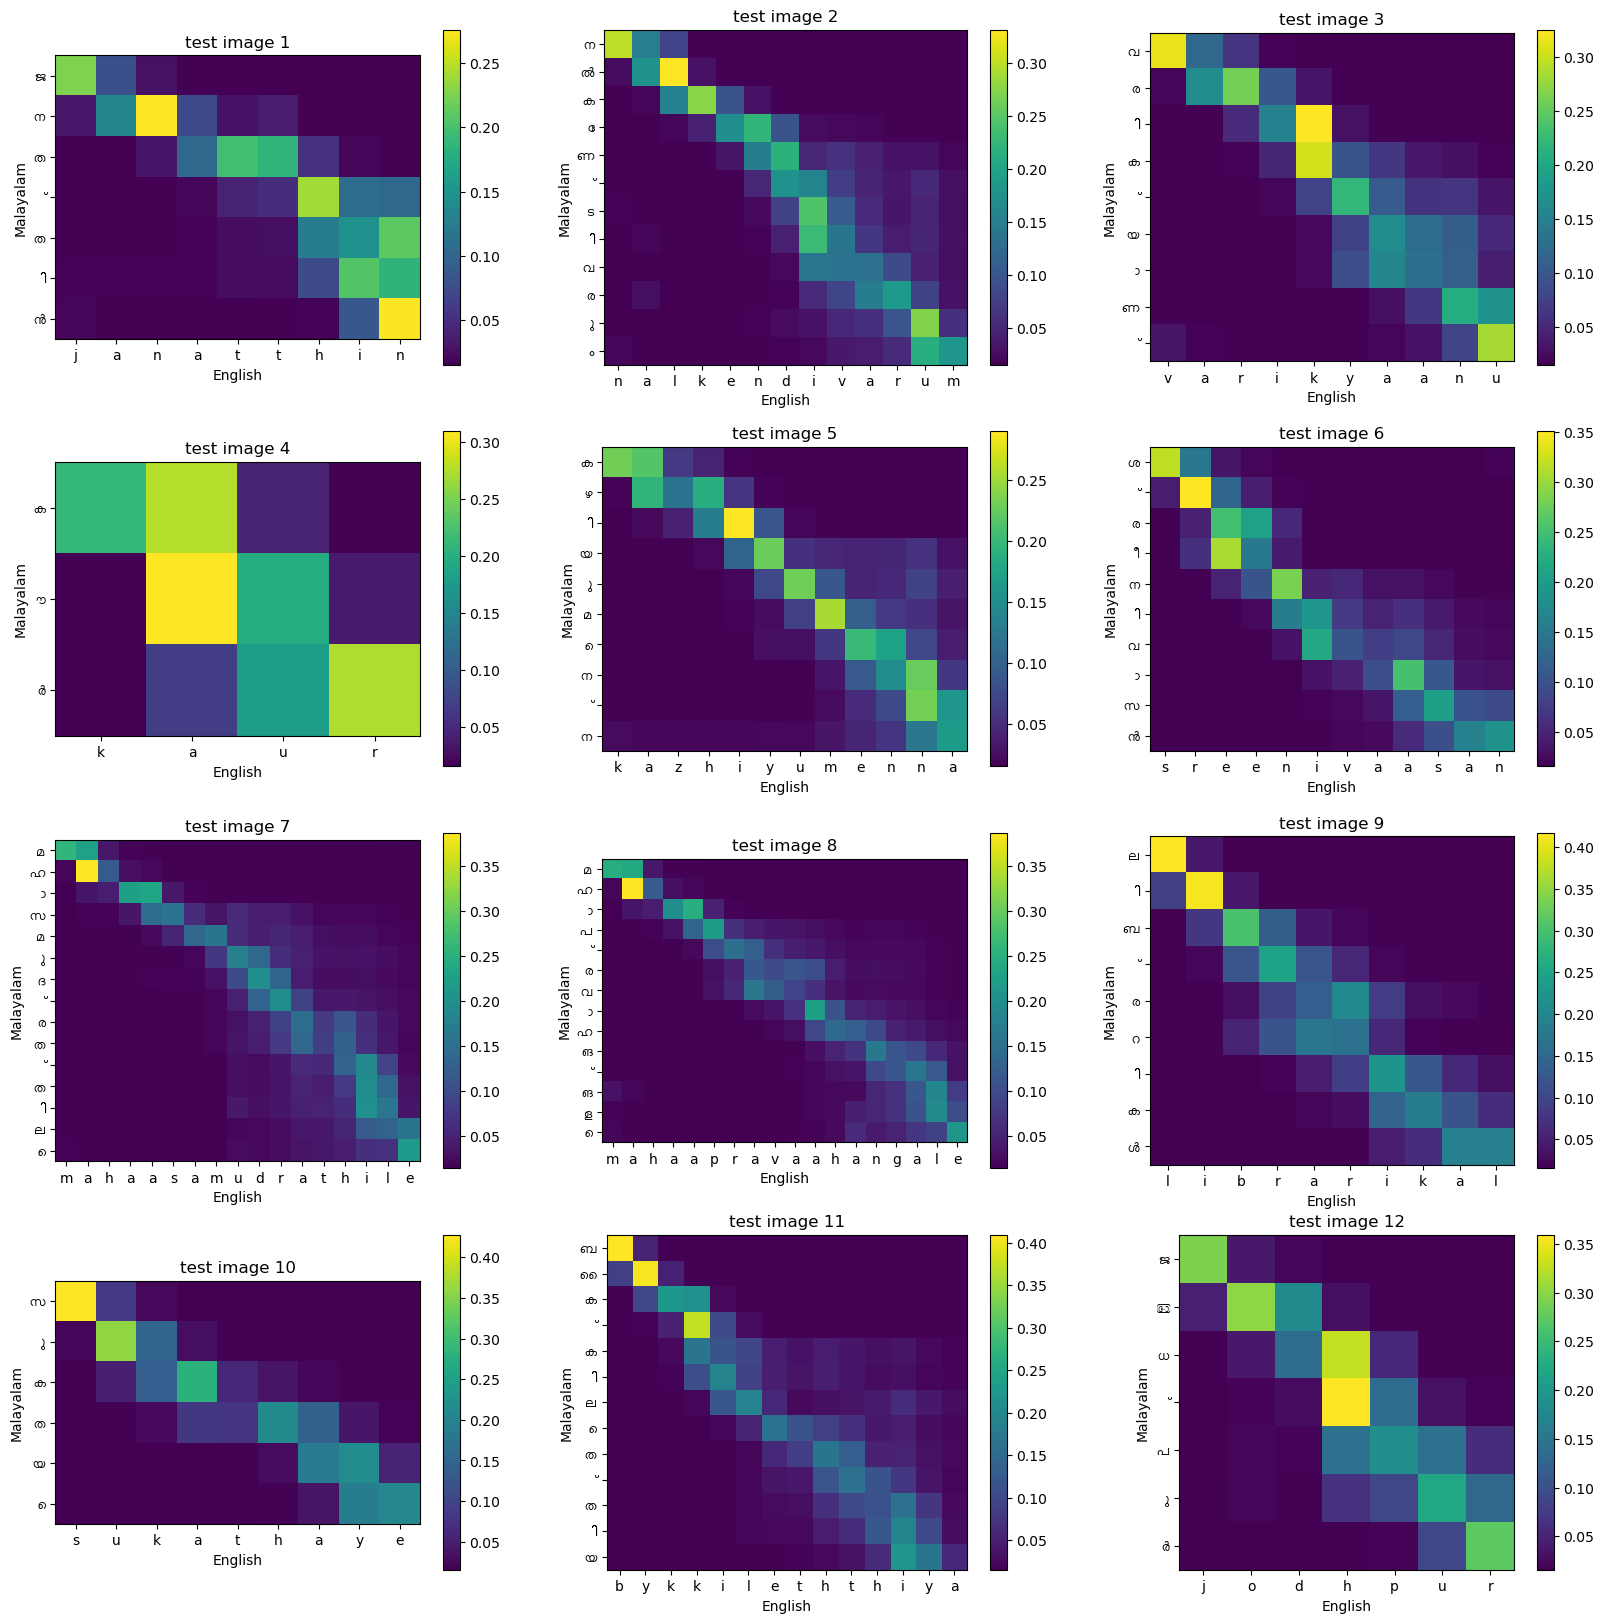

In [71]:
# Plot heatmaps

def getTicks(test_input, acc_output, data_index):
    
    # put ticks into array by iterating test input and predicted of test and converting it into english-malayalam combination
    x_t = []
    y_t = []
    for i in range(len(test_input[data_index])):
        if(test_input[data_index][i].item() != 0 and test_input[data_index][i].item() != 1 and test_input[data_index][i].item() != 2):
            x_t.append(english_index_dict[test_input[data_index][i].item()])

    for i in range(len(acc_output[data_index])):
        if(acc_output[data_index][i].item() != 0 and acc_output[data_index][i].item() != 1 and acc_output[data_index][i].item() != 2):
            y_t.append(malayalam_index_dict[acc_output[data_index][i].item()])
            
    return x_t, y_t

def plotHeatMap(test_input,acc_output,w,num_plots = 12):
    
    # Create subplots
    fig, ax = plt.subplots(4, 3,figsize=(20, 20))
    _ = plt.setp(ax)
    for data_index in range(num_plots):
        
        # get ticks
        x_t, y_t = getTicks(test_input, acc_output, data_index)
        
        # w contains al attention weights for each batches, so take weights batch by batch
        a = w[:,:,data_index]
        a = a.detach().cpu().numpy()
        
        #remove start and end token's weights 
        a = a[1:len(y_t)+1,2:len(x_t)+2] 
        
        # plot 3 subplots per row
        plt.sca(ax[data_index//3,data_index%3])
        
        # Heat map using sns library
#         sns.heatmap(a)
#         plt.xticks(np.arange(0.5, len(x_t)+0.5), x_t)

        # Anjali dataset to be used as correct font for malayalam in ticks for plot
#         mal_font = FontProperties(fname = '/kaggle/input/anjali/AnjaliOldLipi-Regular.ttf')
#         plt.yticks(np.arange(0.5, len(y_t)+0.5), y_t,fontproperties= mal_font)
        
        
        # Heat map using matplotlib
        plt.imshow(a, interpolation='nearest')
        plt.colorbar()
        plt.xticks(np.arange(0, len(x_t)), x_t)
        
        # Anjali dataset to be used as correct font for malayalam in ticks for plot
        mal_font = FontProperties(fname = '/kaggle/input/anjali/AnjaliOldLipi-Regular.ttf')
        
        plt.yticks(np.arange(0, len(y_t)), y_t,fontproperties= mal_font)
        
        plt.xlabel('English')
        plt.ylabel('Malayalam')
        plt.title(f'test image {data_index + 1}')
        
        
#         plt.show()
    canvas = plt.gca().figure.canvas
    canvas.draw()
    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    # Save image to store it into wandb logs
    image = data.reshape(canvas.get_width_height()[::-1] + (3,))
    plt.show()
    
    return image

# store it into wandb

wandb.login(key = KEY)
wandb.init(project = 'dl-assignment-3-final')

if model.use_attention:
    acc_output = F.softmax(test_output,dim=2)
    acc_output = torch.argmax(acc_output,dim=2)
    acc_output.shape
    acc_output = acc_output.T

    w =  torch.mean(_weights,axis=2)
    
    image = plotHeatMap(test_input,acc_output,w)
    wandb.run.name = 'Attention plots'
    wandb.log({"attention_weights_matplotlib" : [wandb.Image(image,caption="Attention weights_matplotlib")]})
else:
    print("No Attention => No heatmap")
wandb.finish()


## WANDB RUN FUNCTION

In [ ]:
# Same as the train loop, but used for wandb running
def runModel(model, data_loader, val_loader ,epochs, beam):
        
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    # set model to train mode
    model.train()
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in tqdm(range(epochs)):
        total_loss=0
        train_loss = 0
        train_score = 0
        val_score = 0
        val_loss = 0
        for i, (source, target) in enumerate(data_loader):

            source = source.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            output,_ = model.forward(source, target, epoch < epochs/2, False)                

            output = output.permute(1, 0, 2)
            expected = F.one_hot(target,num_classes = 72).float()

            output = output.reshape(-1, 72)

            expected = expected.reshape(-1,72)

            loss = criterion(output, expected)

            loss.backward()  # compute gradients
            nn.utils.clip_grad_norm_(model.parameters(),1)
            optimizer.step()  # update parameters

            
        with torch.no_grad():
            model.eval()
            c = 0
            for val_input, val_target in val_loader:
                print(f'batch = > {c}')
                c+=1
                val_input = val_input.to(device)
                val_target = val_target.to(device)
                val_output,_ = model.forward(val_input, None,False,beam)

                acc_output = F.softmax(val_output,dim=2)
                acc_output = torch.argmax(acc_output,dim=2)
                acc_output = acc_output.T
                val_score += scoring(acc_output,val_target)


                val_output = val_output.permute(1, 0, 2)
                expected = F.one_hot(val_target,num_classes = 72).float()

                val_output = val_output.reshape(-1, 72)

                expected = expected.reshape(-1,72)


                loss = criterion(val_output, expected)
                val_loss += loss.item()

        with torch.no_grad():
            model.eval()
            for train_input, train_target in data_loader:
                train_input = train_input.to(device)
                train_target = train_target.to(device)
                train_output,_ = model.forward(train_input, None,False,beam)

                acc_output = F.softmax(train_output,dim=2)
                acc_output = torch.argmax(acc_output,dim=2)
                acc_output = acc_output.T
                train_score += scoring(acc_output,train_target)


                train_output = train_output.permute(1, 0, 2)
                expected = F.one_hot(train_target,num_classes = 72).float()

                train_output = train_output.reshape(-1, 72)

                expected = expected.reshape(-1,72)


                loss = criterion(train_output, expected)
                train_loss += loss.item()
            model.train()



        print(f'epoch {epoch}')
        print(f'train loss => {train_loss/len(data_loader)} \ntrain_acc => {train_score/len(data_loader.dataset)}')
        print(f'valid loss => {val_loss/len(val_loader)} \nvalid_acc => {val_score/len(val_loader.dataset)}')
        train_loss_list.append(train_loss/len(data_loader))
        val_loss_list.append(val_loss/len(val_loader))
        train_accuracy_list.append(train_score/len(data_loader.dataset))
        val_accuracy_list.append(val_score/len(val_loader.dataset))

    return train_loss_list,val_loss_list,train_accuracy_list,val_accuracy_list    


## RUN SINGLE EXAMPLE AND LOG TO WANDB

In [73]:
wandb.login(key = KEY)
wandb.init(project = 'dl-assignment-3-final')
model = Seq2Seq(
    encoder_hidden_dimension = 256, 
    decoder_hidden_dimension =256,
    encoder_embed_dimension = 256, 
    decoder_embed_dimension = 256, 
    bidirectional = True,
    encoder_num_layers = 3,
    decoder_num_layers = 2,
    cell_type = 'lstm', 
    dropout = 0.2,
    beam_width = 3,
    device = device,
    attention = False
)

beam = False
model.to(device)
epochs = 20
train_loss_list,val_loss_list,train_accuracy_list,val_accuracy_list = runModel(model, train_loader, val_loader, epochs, beam)

for i in range(epochs):
    wandb.log({'validation_loss': val_loss_list[i],
              'training_loss': train_loss_list[i],
              'validation_accuracy': val_accuracy_list[i],
              'training_accuracy': train_accuracy_list[i]
              })
# torch.save(model.state_dict(), PATH = '/kaggle/working/top-model')
wandb.finish()


## WANDB SWEEPS TRAIN FUNCTION

In [86]:
def train_wandb():

    wandb.init(project="dl-assignment-3-final")

    wandb.run.name = f'inp_embed_{wandb.config.input_embedding}_enclayer_{wandb.config.number_of_enc_layer}_declayer_{wandb.config.number_of_dec_layer}_hidden_{wandb.config.hidden_size}_cell_{wandb.config.cell_type}_drop_{wandb.config.dropout}'

    # Give wandb parameters
    model = Seq2Seq(   
        encoder_hidden_dimension = wandb.config.hidden_size, 
        decoder_hidden_dimension = wandb.config.hidden_size,
        encoder_embed_dimension =  wandb.config.input_embedding, 
        decoder_embed_dimension =  wandb.config.input_embedding, 
        bidirectional = wandb.config.bidirectional,
        encoder_num_layers = wandb.config.number_of_enc_layer,
        decoder_num_layers = wandb.config.number_of_dec_layer,
        cell_type = wandb.config.cell_type, 
        dropout = wandb.config.dropout, 
        beam_width = wandb.config.beam_width,
        device = device,
        attention = False
    )
    model.to(device)
    beam = True
    epochs = 20
    train_loss_list,val_loss_list,train_accuracy_list,val_accuracy_list = runModel(model, train_loader, val_loader, epochs,beam)
    # Log into wandb
    for i in range(epochs):
        wandb.log({'validation_loss': val_loss_list[i],
                  'training_loss': train_loss_list[i],
                  'validation_accuracy': val_accuracy_list[i],
                  'training_accuracy': train_accuracy_list[i]
                  })
        
        

## WANDB SWEEP CONFIGURATIONS AND RUN SWEEPS

In [ ]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'dl-assignment-3-final',
    'metric': {
        'goal': 'maximize', 
        'name': 'validation_accuracy'
        },
    'parameters': {
        'input_embedding': {'values': [16,32,64,128,256]},
        'number_of_enc_layer': {'values': [1,2,3]},
        'number_of_dec_layer': {'values': [1,2,3]},
        'hidden_size': {'values': [16,32,64,256]},
        'cell_type': {'values': ['rnn','gru','lstm']},
        'dropout': {'values': [0.2,0.3]},
        'bidirectional' : {'values' : [True,False]},
        'beam_width' : {'values' : [1,3,5]}
     }
}

wandb.login(key = KEY)
sweep_id = wandb.sweep(sweep=sweep_configuration, project='dl-assignment-3-final')
wandb.agent(sweep_id, function=train_wandb, count=100)
wandb.finish()

## TEST ACCURACY CALCULATIONS

In [ ]:
# Same as train loop, but calculate accuracy for test
def testAccuracy(model, test_loader):
    model.eval()
    test_score = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    for test_input, test_target in test_loader:
        test_input = test_input.to(device)
        test_target = test_target.to(device)
        test_output,_ = model.forward(test_input, None,False,False)

        acc_output = F.softmax(test_output,dim=2)
        acc_output = torch.argmax(acc_output,dim=2)
        acc_output = acc_output.T
        test_score += scoring(acc_output,test_target)


        test_output = test_output.permute(1, 0, 2)
        expected = F.one_hot(test_target,num_classes = 72).float()

        test_output = test_output.reshape(-1, 72)

        expected = expected.reshape(-1,72)


        loss = criterion(test_output, expected)
        test_loss += loss.item()
        
    print(f'test loss => {test_loss/len(test_loader)} \ntest_acc => {test_score/len(test_loader.dataset)}')
    wandb.log({'test_loss': test_loss/len(test_loader),
                  'test_accuracy': test_score/len(test_loader.dataset)
                  })

# Wandb logs for test

wandb.login(key = KEY)
wandb.init(project = 'dl-assignment-3-final')
wandb.run.name = f'vannilla_test'
testAccuracy(model, test_loader)
wandb.finish()

## STORE SAMPLE OUTPUT FOR TEST DATA

In [31]:
# Function for converting output (malayalam) indexing to native malayalam letters (strings)
def printOutput(y):
    s=''
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 1 or y[i] == 2:
            continue
        s+=malayalam_index_dict[y[i]]
    return s

# Function for converting input (english) indexing to native malayalam letters (strings)
def printInput(y):
    s = ''
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 1 or y[i] == 2:
            continue
        s+=english_index_dict[y[i]]
    return s

# Run the testing loop, but sore the result by calling above functions and store in csv file as english,predicted_malayalam format
def storeSampleOutput(model, test_loader, filename):
    model.eval()
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Input-English','Output-Malayalam','Predicted-Malayalam'])
        for test_input, test_target in test_loader:
            test_input = test_input.to(device)
            test_target = test_target.to(device)
            test_output,_ = model.forward(test_input, None,False,False)

            acc_output = F.softmax(test_output,dim=2)
            acc_output = torch.argmax(acc_output,dim=2)
            acc_output = acc_output.T

            # Create a list of the strings
            for i in range(len(test_input)):
                data = [printInput(test_input[i].detach().cpu().numpy()), printOutput(test_target[i].detach().cpu().numpy()) ,printOutput(acc_output[i].detach().cpu().numpy())]
                
                # Write in row
                writer.writerow(data)
        
    
storeSampleOutput(model, test_loader, 'attention_test_output.csv')  